In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models import resnet34
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import tqdm
import os
import pandas
import random
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
!gdown https://drive.google.com/uc?id=19UmrT9WePvwNGQrwUMayv-qjWMUN7Rf7
!gdown https://drive.google.com/uc?id=1XIzgnjDm3QvFaVu0SWDgd2VZfK4mEcGP
!gdown https://drive.google.com/uc?id=1S2B4pBo6T5kOBwLoryTPM9H25KGO4fjo

Downloading...
From: https://drive.google.com/uc?id=19UmrT9WePvwNGQrwUMayv-qjWMUN7Rf7
To: /content/answer_v2.csv
100% 27.0k/27.0k [00:00<00:00, 3.74MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XIzgnjDm3QvFaVu0SWDgd2VZfK4mEcGP
To: /content/test-20210427T081102Z-001.zip
105MB [00:01, 80.0MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1S2B4pBo6T5kOBwLoryTPM9H25KGO4fjo
To: /content/train-20210427T075941Z-001.zip
619MB [00:07, 90.8MB/s]


In [ ]:
!unzip test-20210427T081102Z-001.zip
!unzip train-20210427T075941Z-001.zip

In [ ]:
answer = pandas.read_csv('answer_v2.csv')
answer

,img_name,defect
0,img_07417,ST3
1,img_04578,ST1
2,img_10744,W
3,img_11378,W
4,img_08499,ST5
...,...,...
1995,img_00960,ND1
1996,img_07706,ST3
1997,img_11466,W
1998,img_02412,PND1


## **SKC defect classification**

All right, let's start then making sure we all know the basics! Let's recognize the ten handwritten digits learning from 60.000, 28x28 grayscale images.

In [ ]:
DEFECT_TO_LABEL = {'BG1': 0, 'BG2': 1, 'ND1': 2, 'ND2': 3, 'ND3': 4, 'ND4': 5, 'ND5': 6, 'ND6': 7, 'ND7': 8, 
                   'PND1': 9, 'PND2': 10, 'PND3': 11, 'PND4': 12, 'PND5': 13, 'PND6': 14, 
                   'ST1': 15, 'ST2': 16, 'ST3': 17, 'ST4': 18, 'ST5': 19, 'ST6': 20, 'ST7': 21, 'W': 22}
LABEL_TO_DEFECT = {label: defect for defect, label in DEFECT_TO_LABEL.items()}

# TODO 1. complete code for train dataset
# defection_list == list of defect to be considered (e.g. ['ST1', 'ND1', ...])
class TrainDataset(Dataset):
  def __init__(self, root, transform, defect_list):
    super().__init__()
    self.root = root
    self.transform = transform
    
    self.defect_list = defect_list

    self.images_path = []
    self.labels = []
    for defect in defect_list:
        fnames = os.listdir(os.path.join(root, defect))
        for fname in fnames:
          self.images_path.append(os.path.join(root, defect, fname))
          self.labels.append(DEFECT_TO_LABEL[defect])

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.transform(Image.open(self.images_path[idx])), self.labels[idx]

# TODO 2. complete code for test dataset
class TestDataset(Dataset):
  def __init__(self, root, transform, defect_list):
    super().__init__()
    self.root = root
    self.transform = transform
    self.defect_list = defect_list

    self.images_path = []
    self.labels = []
    answer = pandas.read_csv('answer_v2.csv')
    for fname, defect in zip(answer['img_name'].tolist(), answer['defect'].tolist()):
      if defect in defect_list:
        self.images_path.append(os.path.join(root, fname + '.bmp'))
        self.labels.append(DEFECT_TO_LABEL[defect])

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return transform(Image.open(self.images_path[idx])), self.labels[idx]

In [ ]:
FIRST_TASK = ['ST1', 'ST2', 'ST3', 'ST4', 'ST5', 'ST6', 'ST7', 'W']
SECOND_TASK = ['BG1', 'BG2', 'ND1', 'ND2', 'ND3', 'ND4', 'ND5', 'ND6', 'ND7']
THIRD_TASK = ['PND1', 'PND2', 'PND3', 'PND4', 'PND5', 'PND6']

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: x.repeat(3, 1, 1) if x.size(0) != 3 else x])

train_dataset1 = TrainDataset('train', transform, FIRST_TASK)
train_dataset2 = TrainDataset('train', transform, SECOND_TASK)
train_dataset3 = TrainDataset('train', transform, THIRD_TASK)

test_dataset1 = TestDataset('test', transform, FIRST_TASK)
test_dataset2 = TestDataset('test', transform, SECOND_TASK)
test_dataset3 = TestDataset('test', transform, THIRD_TASK)

Let's take a look at the actual images!

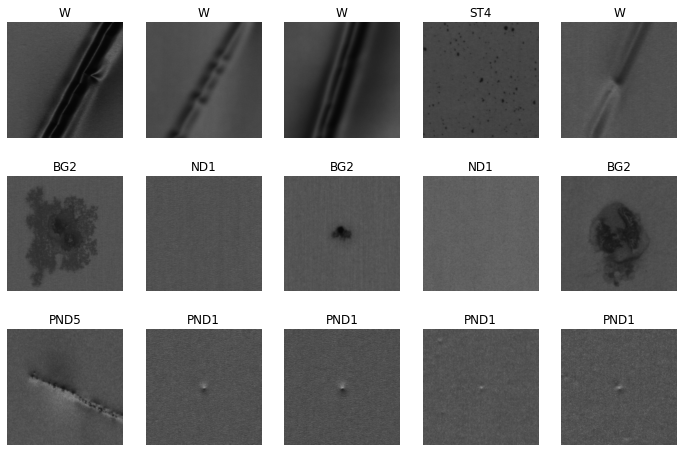

In [ ]:
# TODO 1. plot 5 examples from every train dataset
plt.figure(figsize=(12,8))
for i, train_dataset in enumerate([train_dataset1, train_dataset2, train_dataset3]):
  idxs = random.sample(range(len(train_dataset)), 5)
  
  for j, idx in enumerate(idxs):
    img, lbl = train_dataset[idx]
    plt.subplot(3, 5, i * 5 + j + 1); 
    plt.axis('off')
    plt.imshow(transforms.ToPILImage()(img))
    plt.title(LABEL_TO_DEFECT[lbl])
  
plt.show()

Good! Let's now set up a few general setting before using torch...

In [ ]:
# switch to False to use CPU
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");

model = resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(DEFECT_TO_LABEL))
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

# get data loaders from each of train datset
train_dataloader1 = DataLoader(train_dataset1, batch_size=10, shuffle=True)
train_dataloader2 = DataLoader(train_dataset2, batch_size=10, shuffle=True)
train_dataloader3 = DataLoader(train_dataset3, batch_size=10, shuffle=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
def train(model, device, dataloader, optimizer):
    # TODO 1: complete training code
    # 1) iterate dataloader
    # 2) calculate loss
    # 3) use the optimizer to train the model
    model.train()
    
    for x, y in tqdm.notebook.tqdm(dataloader, desc='train', leave=False):
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()


def test(model, device, dataloader):
    # TODO 2: complete testing code
    # TODO 3: print total loss and accuracy of the model
    # 1) iterate dataloader
    # 2) calculate loss
    # 3) calculate accuracy
    # 4) print results
    model.eval()
    test_loss = 0
    correct = 0
    ns = 0
    for x, y in tqdm.notebook.tqdm(dataloader, desc='test', leave=False):
      with torch.no_grad():
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y)
        pred = torch.argmax(output, dim=1)
        correct += torch.sum(pred == y)
        ns += len(y)

    test_loss /= ns
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, ns,
        100. * correct / ns))
    return 100. * correct / ns

In [ ]:
for ti, train_dataloader in enumerate([train_dataloader1, train_dataloader2, train_dataloader3]):
  print("TASK {}".format(ti))
  train(model, device, train_dataloader, optimizer)
  
  test_dataset = ConcatDataset([test_dataset1, test_dataset2, test_dataset3][:ti + 1])
  test_dataloader = DataLoader(test_dataset, batch_size=10)
  test(model, device, test_dataloader)

TASK 0


Test set: Average loss: 0.0048, Accuracy: 1527/1546 (99%)

TASK 1


Test set: Average loss: 0.6260, Accuracy: 237/1789 (13%)

TASK 2


Test set: Average loss: 0.7178, Accuracy: 212/2000 (11%)



Now, let's use a buffer to contain data of previous tasks and use these preserved data along with newly observed ones for model training.

To do so, we need to build our own buffer object which saves observed data in a limited memory.

In [ ]:
class Buffer():
  def __init__(self, buffer_size):
    self.buffer_size = buffer_size
    self.images = []
    self.labels = []
    self.n = 0

  def __len__(self):
    return len(self.labels)

  def update(self, image, label):
    if self.buffer_size == 0:
      return

    # TODO 1. complete the update function
    # input: a image and label pairs
    # if buffer is not full -> save the input image and label to buffer
    # else -> save the input image and label to buffer with the probability of M/N
    #         M: buffer size, N: the number of examples seen so far.
    if self.n < self.buffer_size:
      self.images.append(image)
      self.labels.append(label)
    else:
      pos = random.randrange(0, self.n)
      if pos < self.buffer_size:
        self.images[pos] = image
        self.labels[pos] = label
    self.n += 1
  
  def sample(self, sample_num):
    # TODO 2. complete the sample function
    # input: sample num (if sample_num=5, 5 image and label pairs must be returned)
    # output: sampled image tensor shape==(# batch_size, # channels, width, height),
    #         sampled label tensor shape==(# batch_size)
    poss = random.sample(range(len(self)), sample_num)
    images = [self.images[pos] for pos in poss]
    labels = [self.labels[pos] for pos in poss]
    return torch.stack(images), torch.stack(labels)

Then we can write the *train* and *test* functions. 

In [ ]:
def train_w_buff(model, buffer, device, dataloader, optimizer):
    model.train()
    
    for x, y in tqdm.notebook.tqdm(dataloader, desc='train', leave=False):
      x, y = x.to(device), y.to(device)

      # TODO 1: if the buffer has examples in it, sample data
      #         and combine with the newly observed x and y.
      if len(buffer) > 0:
        sample_num = min(len(x), len(buffer))
        buff_imgs, buff_lbls = buffer.sample(sample_num)
        x = torch.cat([x, buff_imgs])
        y = torch.cat([y, buff_lbls])

      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()

      # TODO 2: save x and y into the buffer
      for img, lbl in zip(x, y):
        buffer.update(img.detach(), lbl.detach())


Then we are ready to instantiate our model and start the training!

In [ ]:
# TODO 1: load pretrained resnet34 from the torchvision
model = resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(DEFECT_TO_LABEL))
model.to(device)

# TODO 2: get optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# TODO 3. get data loaders from each of train datset
train_dataloader1 = DataLoader(train_dataset1, batch_size=10, shuffle=True)
train_dataloader2 = DataLoader(train_dataset2, batch_size=10, shuffle=True)
train_dataloader3 = DataLoader(train_dataset3, batch_size=10, shuffle=True)

# TODO 4: instantiate the buffer of size 300
buffer_size = 300
buffer = Buffer(buffer_size)

In [ ]:
for ti, train_dataloader in enumerate([train_dataloader1, train_dataloader2, train_dataloader3]):
  print("TASK {}".format(ti))
  train_w_buff(model, buffer, device, train_dataloader, optimizer)
  
  test_dataset = ConcatDataset([test_dataset1, test_dataset2, test_dataset3][:ti + 1])
  test_dataloader = DataLoader(test_dataset, batch_size=10)
  test(model, device, test_dataloader)

TASK 0


Test set: Average loss: 0.0067, Accuracy: 1517/1546 (98%)

TASK 1


Test set: Average loss: 0.0335, Accuracy: 1610/1789 (90%)

TASK 2


Test set: Average loss: 0.0306, Accuracy: 1843/2000 (92%)



If we have all of our data, we can get the best model without the help of the buffer. 

In [ ]:
model = resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(DEFECT_TO_LABEL))
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# TODO 1: concat all of train datast and get dataloader for it
train_dataset = ConcatDataset([train_dataset1, train_dataset2, train_dataset3])
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

# TODO 2: concat all of test datast and get dataloader for it
test_dataset = ConcatDataset([test_dataset1, test_dataset2, test_dataset3])
test_dataloader = DataLoader(test_dataset, batch_size=10)

# TODO 3: train the model and test its performance
print('Combined tasks')
train(model, device, train_dataloader, optimizer)
test(model, device, test_dataloader)

Combined tasks


Test set: Average loss: 0.0272, Accuracy: 1922/2000 (96%)



tensor(96.1000, device='cuda:0')